## Importing Necessary Packages and Modules

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from pathlib import Path

import os
from tqdm import tqdm
import random


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata

# my custom modules
import data_utils as du
import nn_tools as nt
import model_eval as me

os.chdir('/Users/Mak/Desktop/Imperial College London/Year Four/MSci Project/Codebase/')
DEVICE = torch.device("mps")

s = 42

torch.use_deterministic_algorithms(True)
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

np.random.seed(s)
torch.manual_seed(s)
torch.mps.manual_seed(s)
random.seed(s)


## Specifying Data Paths and Values

In [2]:
# change the first one to the folder name where the raw eos data is stored
# change the second argument to specify the name of the root folder where you want to store
# the normalised data/processed data

normal_path = 'nn_outputs/wilson_csr_cvr_bkg'
raw_path = 'raw_data/dstore_csr_cvr'
number_bins = 10
test_amt = 1448

In [4]:
#### - Pass through raw data, provide output path for normalised data -

# =-=-=-= Takes very long, so execute once per dataset and save to prevent rerunning costs =-=-=-=

du.file_to_normalise_4d(raw_path, normal_path, number_bins, bkg=True)

Processing File No. model_WET_mu_1411: 100%|██████████| 1805/1805 [05:04<00:00,  5.93it/s]


In [5]:
train_inputs, train_targets, test_inputs, test_targets, file_names = du.load_minmax_heights(normal_path, test_amt)

In [6]:
# - Configuration Dictionary - Need to implement modularity with NN modules -
cfg = {'batch_train' : 32,
       'batch_test' : 8,
       'epochs' : 25,
       'dim': (len(train_inputs[0]), len(train_targets[0])),
       'lr' : 0.05,
       'loss_func' : nn.HuberLoss(delta=0.2)}

# - Prepare DataLoaders - Training Set -
load_train = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=cfg['batch_train'], shuffle=True, num_workers=0)

# - Testing Set -
load_test = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=cfg['batch_test'], shuffle=False, num_workers=0)

# - Visualisation Set - Testing Set, Batch size = 1 -
load_vis = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=1, shuffle=False, num_workers=0)

In [7]:
# - Model initialisation and dimension specification -
loss_func = cfg['loss_func']
base = nt.base_model(*cfg['dim'])
base.to(DEVICE)

# - Optimiser specified -
optimiser = torch.optim.AdamW(base.parameters(), lr=3e-4, weight_decay=1e-4)

# - Training Loop - train_epoch function in nn_tools -
loss_evol = []

for epoch in (pbar := tqdm(range(cfg['epochs']))):
    avg_loss = nt.train_epoch(base, load_train, loss_func, optimiser, DEVICE)
    pbar.set_description(f"Training Epoch: {epoch}/{cfg['epochs']}, Avg. Loss: {avg_loss:.4f}")

    loss_evol.append(avg_loss)

# - Change normal path where appropriate -
save_path = normal_path + '/mu_4d.pth'
torch.save(base.state_dict(), save_path)

# plt.plot(list(range(cfg['epochs'])), loss_evol)

Training Epoch: 24/25, Avg. Loss: 0.0008: 100%|██████████| 25/25 [00:39<00:00,  1.60s/it]


After training, having saved the model state, we can define the testing data loaders, load the best state that we arrived at above, and use the test_visualise function to store the model passthrough for the testing set as csvs. This is important as the cell after this plots out the nn outputs against the eos simulations to compare its performance.

In [8]:
best_model = nt.base_model(*cfg['dim'])

# - Load best model data -
best_model.load_state_dict(torch.load(save_path, weights_only = False))
best_model.to(DEVICE)

# - Testing passthrough - does not need loop - maybe expand to enable easy visualisation -
out = nt.test_epoch(best_model, load_test, loss_func, DEVICE)
print('Average Loss of Test Set', out)

# - Store model outputs as csvs to be used later -
store_test = nt.test_visualise_4d(best_model, load_vis, DEVICE, test_amt, normal_path, number_bins, file_names)

Average Loss of Test Set 0.0008546826559015446


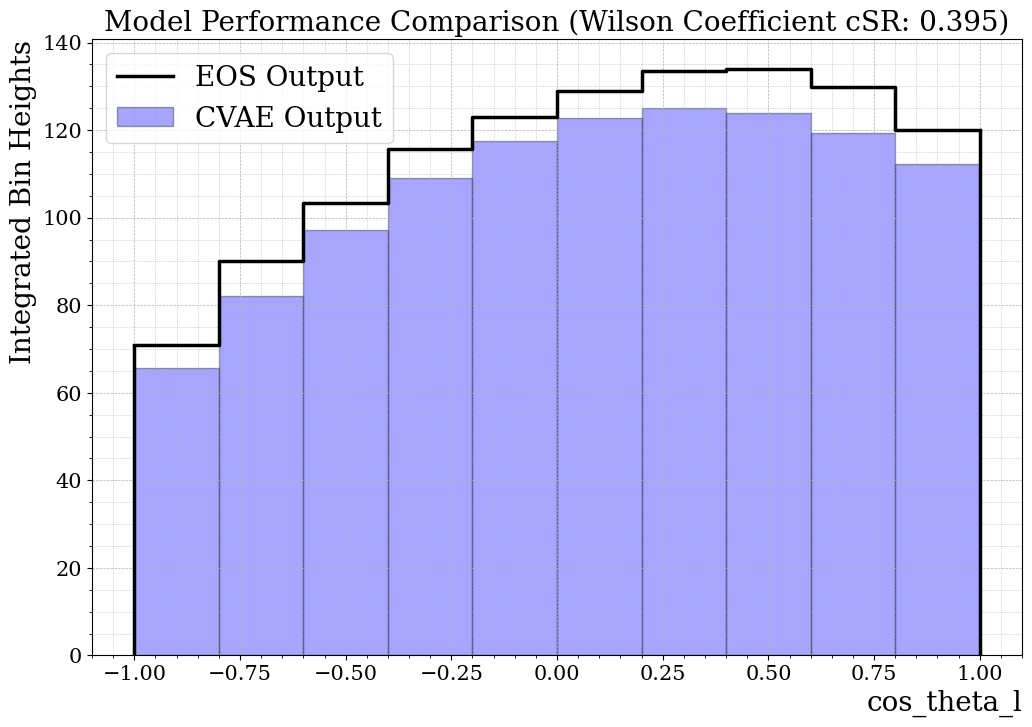

In [11]:
import importlib
import model_eval as me # Import your module
importlib.reload(me)  # Reload the module

me.plot_1d_stk(data_path="nn_outputs/wilson_csr_bkg", x_var='cos_theta_l', filenumber=102)

# Conditional Variational AutEncoder:

This contains the same structure as the above, this time for a CVAE architecture.

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from pathlib import Path
import json
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import optuna


# my custom modules
import data_utils as du
import nn_tools as nt
import model_eval as me

os.chdir('/Users/Mak/Desktop/Imperial College London/Year Four/MSci Project/Codebase/')
DEVICE = torch.device("mps")

s = 42

torch.use_deterministic_algorithms(True)
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

np.random.seed(s)
torch.manual_seed(s)
torch.mps.manual_seed(s)
random.seed(s)

import importlib

importlib.reload(me)
importlib.reload(nt)
importlib.reload(du)


<module 'data_utils' from '/Users/Mak/Desktop/Imperial College London/Year Four/MSci Project/Codebase/data_utils.py'>

# Training CVAE

In [9]:
normal_path = 'nn_outputs/wilson_tau_csr_cvr'
raw_path = 'raw_data/dstore_tau_csr_cvr'
number_bins = 10
test_amt = 1400

In [4]:
du.file_to_normalise_4d(raw_path, normal_path, number_bins, bkg=False)

Processing File No. model_WET_tau_633: 100%|██████████| 1792/1792 [05:03<00:00,  5.90it/s] 


In [10]:
train_inputs, train_targets, test_inputs, test_targets, file_names = du.load_minmax_heights(normal_path, test_amt)

In [11]:
cfg_CVAE = {'batch_train' : 64,
       'batch_test' : 8,
       'epochs' : 150,
       'dim': [len(train_inputs[0]), len(train_targets[0])],
       }

# - Prepare DataLoaders - Training Set -
load_train = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=cfg_CVAE['batch_train'], shuffle=True, num_workers=0)

# - Testing Set -
load_test = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=cfg_CVAE['batch_test'], shuffle=False, num_workers=0)

# - Visualisation Set - Testing Set, Batch size = 1 -
load_vis = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=1, shuffle=False, num_workers=0)

In [13]:
# - Model initialisation and dimension specification -
loss_func = nt.loss_function
base = nt.CVAE(input_shape=cfg_CVAE['dim'][0], output_shape=cfg_CVAE['dim'][1], latent_dim=40)
base.to(DEVICE)

# - Optimiser specified -
optimiser = torch.optim.AdamW(base.parameters(), lr=1e-3, weight_decay=1e-4)

loss_evol = []
val_loss_evol = []

early_stopping_patience = 10
best_val_loss = np.inf
epochs_without_improvement = 0

# Training loops
for epoch in (pbar := tqdm(range(cfg_CVAE['epochs']))):
    avg_loss, avg_val_loss = nt.train_epoch_early_CVAE(base, load_train, load_test, loss_func, optimiser, DEVICE)
    pbar.set_description(f"Training Epoch: {epoch + 1}/{cfg_CVAE['epochs']}, Avg. Loss: {avg_loss:.4f}")

    loss_evol.append(avg_loss)
    val_loss_evol.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0

    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# - Change normal path where appropriate -
save_path = normal_path + '/CVAE_tau_4d.pth'
torch.save(base.state_dict(), save_path)

# plt.plot(list(range(cfg['epochs'])), loss_evol)

Training Epoch: 116/150, Avg. Loss: 0.0010:  77%|███████▋  | 115/150 [00:42<00:13,  2.67it/s]

Early stopping triggered after 116 epochs.


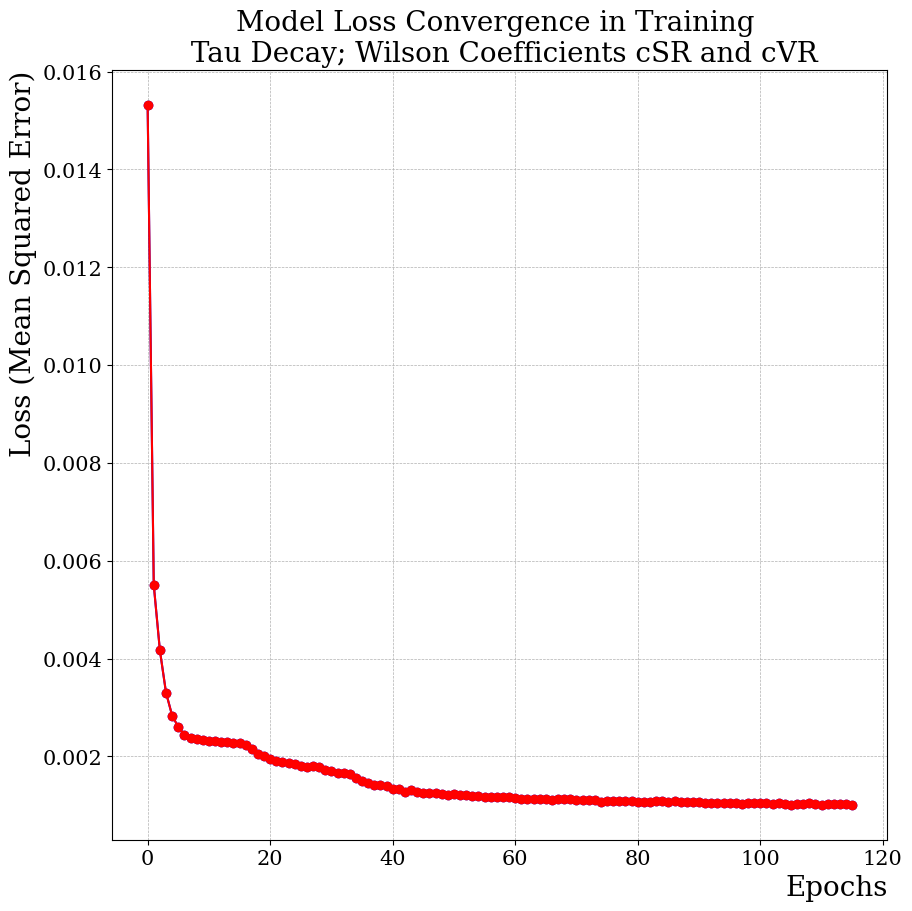

In [18]:
cfg = {}
cfg['epochs'] = 116

plt.figure(figsize=(10, 10))
plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 15
plt.plot(list(range(cfg['epochs']))[:len(loss_evol)], loss_evol, 'o-', color='blue', label='Training Loss')
plt.plot(list(range(cfg['epochs']))[:len(val_loss_evol)], loss_evol, 'o-', color='red', label='Validation Loss')

plt.xlabel('Epochs', fontsize=20, loc='right')
plt.ylabel('Loss (Mean Squared Error)', fontsize=20, loc='top')
plt.title('Model Loss Convergence in Training \n Tau Decay; Wilson Coefficients cSR and cVR', fontsize=20)

plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

# Testing CVAE

In [8]:
loss_func = nt.loss_function
save_path = normal_path + '/CVAE_tau_4d.pth'
best_model = nt.CVAE(input_shape=cfg_CVAE['dim'][0], output_shape=cfg_CVAE['dim'][1], latent_dim=40)
# best_model = nt.CVAE_Opt(input_shape=cfg_CVAE['dim'][0], output_shape=cfg_CVAE['dim'][1], latent_dim=latent, encoder_layers=encoder_form, decoder_layers=decoder_form,
#                  dropout_enc=encoder_drops, dropout_dec=decoder_drops)

# - Load best model data -
best_model.load_state_dict(torch.load(save_path, weights_only = False))
best_model.to(DEVICE)

# - Testing passthrough - does not need loop - maybe expand to enable easy visualisation -
out = nt.test_epoch_CVAE(best_model, load_test, loss_func, DEVICE)
print('Average Loss of Test Set', out)

# # - Store model outputs as csvs to be used later -
store_test = nt.test_visualise_4d_CVAE(best_model, load_vis, DEVICE, test_amt, normal_path, number_bins, file_names)

Average Loss of Test Set 0.0010743137943197269


392it [00:09, 40.51it/s]


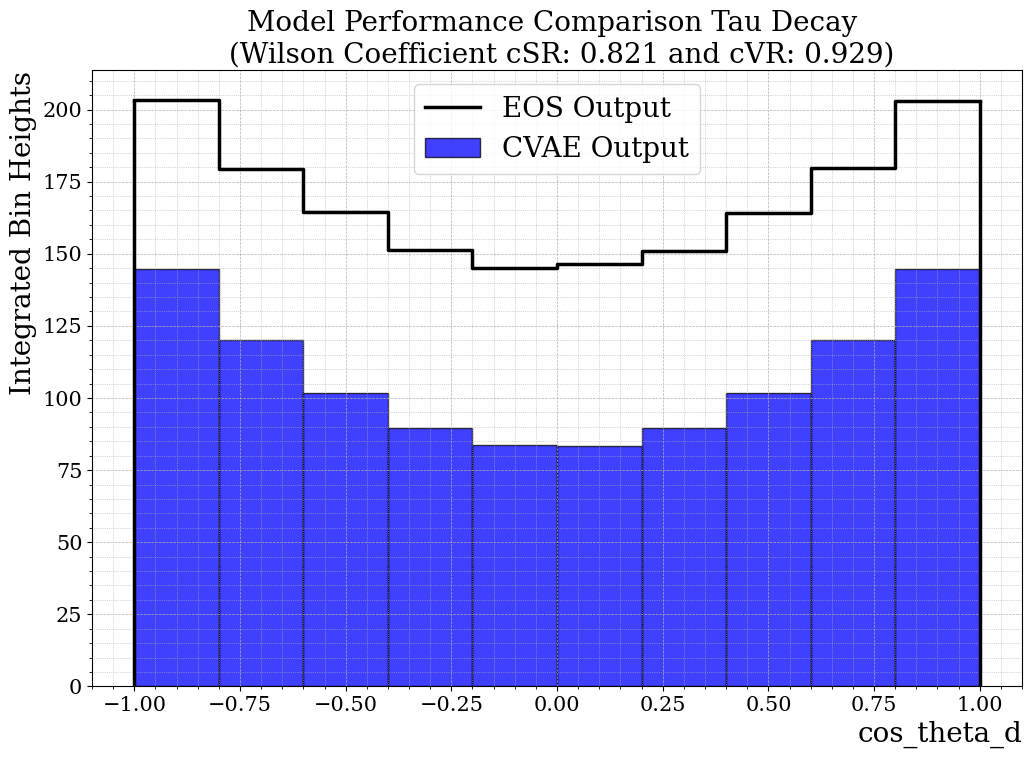

In [7]:
import importlib
import model_eval as me # Import your module
importlib.reload(me)  # Reload the module

def plot_1d_stk_tau(data_path, x_var, filenumber):

    """
        Generates a 3D surface plot for one dataset and overlays a second dataset for comparison.

        Parameters:
        - data_path (str): Path to the CSV file.
        - x_var (str): Column name for the x-axis variable.
        - y_var (str): Column name for the y-axis variable.
        - integrate_vars (list): List of column names to integrate (sum) over.
        - comparison_data (pd.DataFrame): Second dataset with two columns (x_var, y_var) and one row.
        - bin_height (str): Column name for the bin heights (default: "bin_height").
        - grid_size (int): Resolution of the interpolation grid (default: 50).
        - cmap: Colormap for the surface plot (default: cm.viridis).
        """

    # Both share the same base directory, stored in normal_targets and model_outputs separately
    eos_path = os.path.join(data_path, f'normal_targets/model_WET_tau_{filenumber}.csv')
    nn_path = os.path.join(data_path, f'model_outputs/model_WET_tau_{filenumber}.csv')

    input_data = os.path.join(data_path, f'normal_inputs/model_WET_tau_{filenumber}.json')

    with open(input_data, 'r') as f:
        wilson_info = json.load(f)
    
    wc = wilson_info['wc_0']
    wc_2 = wilson_info['wc_1']

    df_eos = pd.read_csv(eos_path)
    df_nn = pd.read_csv(nn_path)

    # Integrate over the remaining two columns to produce 3D plots
    df_eos_integrated = df_eos.groupby([x_var])["bin_height"].sum().reset_index()
    df_nn_integrated = df_nn.groupby([x_var])["bin_height"].sum().reset_index()

    x_unq = np.unique(df_eos_integrated[x_var].values)

    # extract the bin_midpoints - both datasets share the same bin_midpoints
    if x_var != 'q2' and x_var != 'phi':
        x_unq = (x_unq * 2) - 1
    
    elif x_var == 'q2':
        x_unq = (x_unq * 10.48) - 0.02

    else:
        x_unq =(x_unq * 2 * np.pi) 

    # The heights however are different and need to be extracted
    height_eos = df_eos_integrated["bin_height"].values
    height_nn = df_nn_integrated["bin_height"].values

    plt.rcParams["font.family"] = "Serif"
    plt.rcParams['font.size'] = 15

    w = np.diff(x_unq)[-1]
    # Create subplots
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the NN dataset
    ax.bar(x_unq, height_nn, width=w, color='blue', edgecolor='black', alpha=0.75, label='CVAE Output')

    # Plot the EOS dataset
    ax.step(np.append(x_unq, x_unq[-1] + w) - w/2, np.append(height_eos, height_eos[-1]), where='post', color='black', 
            linewidth=2.5, label='EOS Output')
    ax.vlines(x_unq[0] - w/2, 0, height_eos[0], color='black', linewidth=2.5)
    ax.vlines(x_unq[-1] + w/2, 0, height_eos[-1], color='black', linewidth=2.5)

    # cs_nn = CubicSpline(x_unq, height_nn)
    # cs_eos = CubicSpline(x_unq, height_eos)

    # x_span = np.linspace(min(x_unq), max(x_unq), 200, endpoint=True)

    # ax.plot(x_span, cs_nn(x_span), color='blue')
    # ax.plot(x_span, cs_eos(x_span), color='red')

    # Add labels and title
    ax.set_xlabel(f'{x_var}', fontsize=20, loc='right')
    ax.set_ylabel('Integrated Bin Heights', fontsize=20, loc='top')
    ax.set_title(f'Model Performance Comparison Tau Decay \n (Wilson Coefficient cSR: {wc:.3f} and cVR: {wc_2:.3f})', fontsize=20)

    # Add minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle=':', linewidth=0.5)

    # Add legend
    ax.legend(fontsize=20)

    plt.show()

    fig.suptitle(f"Wilson Coefficient cSR: {wc:.3f} and cVR: {wc_2:.3f}")
    fig.savefig('EOS_Integrated.jpeg')
    
    plt.show()

plot_1d_stk_tau(data_path="nn_outputs/wilson_tau_csr_cvr", x_var='cos_theta_d', filenumber=50)

# Number of Parameters:

Comparing the number of parameters in each model.

In [17]:
def count_parameters(state_dict):
    total_params = 0
    for param_tensor in state_dict:
        total_params += state_dict[param_tensor].numel()
    return total_params

# Load the state dictionary from the .pth file
state_dict = torch.load('nn_outputs/wilson_csr_cvr/mu_4d.pth', weights_only=False)

# Count the number of parameters
total_params = count_parameters(state_dict)

print(f'Total number of parameters: {total_params}')

Total number of parameters: 23291289


## Computational Efficiency:

The below cell simply finds the run-time and memory efficiency of the constructed module to give numbers to be used in actual evaluation.

In [ ]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psutil

fixed_inputs = torch.Tensor([0.5, 0.5]).to(DEVICE)
csr_model_gen = nt.CVAE(input_shape=fixed_inputs.shape[0], output_shape=10000, latent_dim=40)
csr_model_gen.load_state_dict(torch.load('nn_outputs/wilson_csr_cvr/CVAE_mu_4d.pth', weights_only=False))
csr_model_gen.to(DEVICE)

model_heights_list = []
time_list = []
memory_usage_list = []



process = psutil.Process()

for i in range(50):
    with torch.no_grad():
        start_time = time.time()

        # Measure memory usage before model generation
        mem_before = process.memory_info().rss

        sample = csr_model_gen.generate_histogram(fixed_inputs)

        # Measure memory usage after model generation
        mem_after = process.memory_info().rss

        end_time = time.time()
        sample = sample.cpu().numpy()

        # Calculate memory usage for the model generation
        mem_usage = mem_after - mem_before
        memory_usage_list.append(mem_usage)

        xpos, ypos, zpos, wpos = np.meshgrid(bins, bins, bins, bins, indexing="ij")

        # Flatten the arrays and create the resulting DataFrame
        result_df = pd.DataFrame({
            'q2': xpos.ravel(),
            'cos_theta_l': ypos.ravel(),
            'cos_theta_d': zpos.ravel(),
            'phi': wpos.ravel(),
            'bin_height': np.squeeze(sample)
        })

        delta = end_time - start_time

        time_list.append(delta)
        model_heights_list.append(sample)


# Print memory usage statistics
print(f"Average memory usage per iteration: {np.mean(memory_usage_list) / (1024 ** 2):.2f} MB")
print(f"Maximum memory usage in an iteration: {np.max(memory_usage_list) / (1024 ** 2):.2f} MB")
print(f"Minimum memory usage in an iteration: {np.min(memory_usage_list) / (1024 ** 2):.2f} MB")